In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import torch
from matplotlib import pyplot as plt

from counterfactuals.datasets import HelocDataset
from counterfactuals.losses import MulticlassDiscLoss
from counterfactuals.cf_methods.group_ppcef.rppcef import RPPCEF
from counterfactuals.generative_models import MaskedAutoregressiveFlow
from counterfactuals.discriminative_models import MultilayerPerceptron
from counterfactuals.metrics import CFMetrics

In [6]:
# dataset = MnistDataset("../data/mnist.csv")
# dataset = LawDataset("../data/law.csv")
dataset = HelocDataset("../data/heloc.csv")
# dataset = AuditDataset("../data/audit.csv")
# dataset = MoonsDataset("../data/moons.csv")

In [7]:
disc_model = MultilayerPerceptron(dataset.X_test.shape[1], [512, 512], 2)
# disc_model.fit(
#     dataset.train_dataloader(batch_size=128, shuffle=True),
#     dataset.test_dataloader(batch_size=128, shuffle=False),
#     epochs=5000,
#     patience=100,
#     lr=1e-3,
#     checkpoint_path="disc_model.pt",
# )
disc_model.load("heloc_disc_model.pt")

/home/lukasz/genwro/counterfactuals/counterfactuals/discriminative_models/multilayer_perceptron.py:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(to

In [8]:
# disc_model = LogisticRegression(dataset.X_test.shape[1], 1)
# disc_model.fit(
#     dataset.train_dataloader(batch_size=256, shuffle=True),
#     dataset.test_dataloader(batch_size=256, shuffle=False),
#     epochs=5000,
#     patience=100,
#     checkpoint_path="disc_model.pt",
# )
# # disc_model.load("disc_model.pt")

In [9]:
y_pred = disc_model.predict(dataset.X_test).detach().numpy().flatten()
print("Test accuracy:", (y_pred == dataset.y_test).mean())

Test accuracy: 0.7179746835443038


In [10]:
dataset.y_train = disc_model.predict(dataset.X_train).detach().numpy()
dataset.y_test = disc_model.predict(dataset.X_test).detach().numpy()

In [11]:
# dataset = MoonsDataset("../data/moons.csv")
# dataset = MnistDataset("../data/mnist.csv")
# train_dataloader = dataset.train_dataloader(batch_size=1024, shuffle=True)
# test_dataloader = dataset.test_dataloader(batch_size=1024, shuffle=False)

# disc_model = LogisticRegression(dataset.X_test.shape[1], 1)
# disc_model.fit(
#     dataset.train_dataloader(batch_size=1024, shuffle=True),
#     dataset.test_dataloader(batch_size=1024, shuffle=False),
#     epochs=1000
# )

gen_model = MaskedAutoregressiveFlow(
    features=dataset.X_train.shape[1],
    hidden_features=16,
    num_blocks_per_layer=2,
    num_layers=5,
    context_features=1,
    batch_norm_within_layers=True,
    batch_norm_between_layers=True,
    use_random_permutations=True,
)
train_dataloader = dataset.train_dataloader(
    batch_size=256, shuffle=True, noise_lvl=0.03
)
test_dataloader = dataset.test_dataloader(batch_size=256, shuffle=False)

# gen_model.fit(
#     train_dataloader,
#     train_dataloader,
#     learning_rate=1e-3,
#     patience=100,
#     num_epochs=500,
#     checkpoint_path="heloc_flow.pth"
# )
gen_model.load("heloc_flow.pth")

/home/lukasz/genwro/counterfactuals/counterfactuals/generative_models/maf/maf.py:154: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


In [12]:
torch.norm(torch.randn(6, 23), p=1, dim=1)

tensor([18.4236, 20.9694, 17.7429, 16.4280, 21.0096, 15.7474])

In [13]:
# with torch.no_grad():
#     plt.imshow(gen_model.sample_and_log_prob(1, context=torch.tensor([1.0]))[0].view(28, 28).detach().numpy(), cmap="gray")

In [14]:
# plt.imshow(dataset.X_train[6].reshape(28, 28), cmap="gray")

In [15]:
source_class = 0
target_class = 1
X_test_origin = dataset.X_test[dataset.y_test == source_class]
y_test_origin = dataset.y_test[dataset.y_test == source_class]

In [17]:
dataset.actionable_features = [0, 1, 2, 3, 4]
dataset.not_actionable_features = [
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
]
cf_method = RPPCEF(
    X=X_test_origin,
    cf_method_type="GCE",
    K=6,
    gen_model=gen_model,
    disc_model=disc_model,
    disc_model_criterion=MulticlassDiscLoss(),
    # actionable_features=None,
    # TODO: poprawa nazewnictwa
    actionable_features=dataset.not_actionable_features,
    neptune_run=None,
)

train_dataloader_for_log_prob = dataset.train_dataloader(batch_size=4096, shuffle=False)
log_prob_threshold = torch.quantile(
    gen_model.predict_log_prob(train_dataloader_for_log_prob),
    0.25,
)

print("#")
print(log_prob_threshold)

cf_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(X_test_origin).float(),
        torch.tensor(y_test_origin).float(),
    ),
    batch_size=4096,
    shuffle=False,
)


delta, Xs, ys_orig, ys_target = cf_method.explain_dataloader(
    dataloader=cf_dataloader,
    epochs=3000,
    lr=0.003,
    patience=300,
    alpha=100,
    alpha_s=1000,
    alpha_k=100,
    log_prob_threshold=log_prob_threshold,
)

M, S, D = delta.get_matrices()
Xs_cfs = Xs + delta().detach().numpy()

values, indexes = S.max(dim=1)

total = len(values)
i_correct = indexes[values == 1]
print(f"Correct: {len(i_correct)}/{total}")
print(len(set(i_correct.tolist())))

metrics = CFMetrics(
    X_cf=Xs_cfs,
    y_target=ys_target,
    X_train=dataset.X_train,
    y_train=dataset.y_train,
    X_test=X_test_origin,
    y_test=y_test_origin,
    disc_model=disc_model,
    gen_model=gen_model,
    continuous_features=list(range(dataset.X_train.shape[1])),
    categorical_features=dataset.categorical_features,
    prob_plausibility_threshold=log_prob_threshold,
)
metrics.calc_all_metrics()

#
tensor(-34.3466)


  0%|          | 0/3000 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

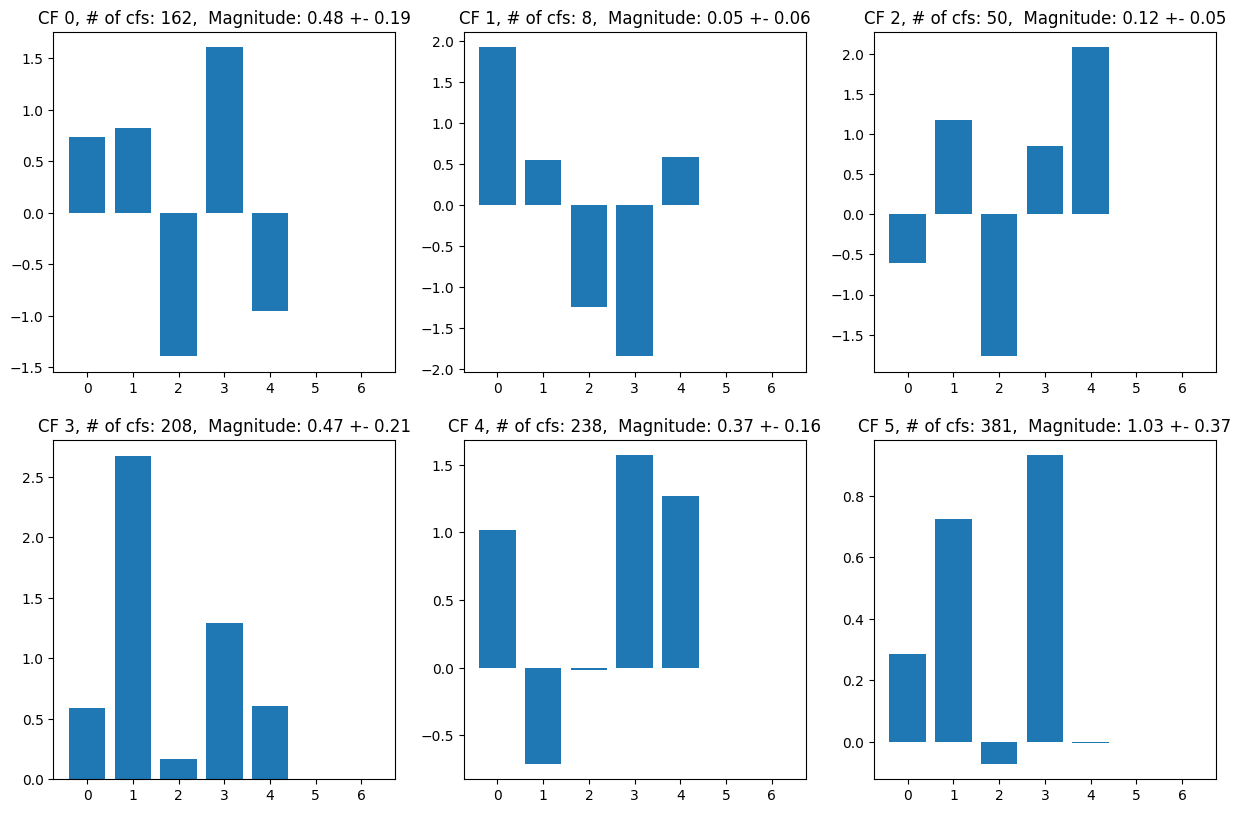

In [14]:
plt.figure(figsize=(15, 15))

groups = S.argmax(dim=1)

for i in range(D.shape[0]):
    plt.subplot(3, 3, i + 1)
    plt.bar(range(7), D[i, :7].detach().numpy())
    mean_magn = M.squeeze()[groups == i].mean(axis=0)
    std_magn = M.squeeze()[groups == i].std(axis=0)
    n_vectors = (S.argmax(axis=1) == i).sum()
    plt.title(
        f"CF {i}, # of cfs: {n_vectors},  Magnitude: {mean_magn:.2f} +- {std_magn:.2f}"
    )

In [15]:
dataset.not_actionable_features = [
    0,
    1,
    2,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
]
dataset.actionable_features = [3, 4, 5, 6, 7, 8]
cf_method = RPPCEF(
    X=X_test_origin,
    cf_method_type="GCE",
    K=6,
    gen_model=gen_model,
    disc_model=disc_model,
    disc_model_criterion=MulticlassDiscLoss(),
    # actionable_features=None,
    actionable_features=dataset.not_actionable_features,
    neptune_run=None,
)

train_dataloader_for_log_prob = dataset.train_dataloader(batch_size=4096, shuffle=False)
log_prob_threshold = torch.quantile(
    gen_model.predict_log_prob(train_dataloader_for_log_prob),
    0.25,
)

cf_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(X_test_origin).float(),
        torch.tensor(y_test_origin).float(),
    ),
    batch_size=4096,
    shuffle=False,
)


delta, Xs, ys_orig, ys_target = cf_method.explain_dataloader(
    dataloader=cf_dataloader,
    epochs=3000,
    lr=0.003,
    patience=300,
    alpha=100,
    alpha_s=1000,
    alpha_k=100,
    log_prob_threshold=log_prob_threshold,
)

M, S, D = delta.get_matrices()
Xs_cfs = Xs + delta().detach().numpy()


metrics = CFMetrics(
    X_cf=Xs_cfs,
    y_target=ys_target,
    X_train=dataset.X_train,
    y_train=dataset.y_train,
    X_test=X_test_origin,
    y_test=y_test_origin,
    disc_model=disc_model,
    gen_model=gen_model,
    continuous_features=list(range(dataset.X_train.shape[1])),
    categorical_features=dataset.categorical_features,
    prob_plausibility_threshold=log_prob_threshold,
)
metrics.calc_all_metrics()

loss: 1061.7606, dist: 1.3639, max_inner: 7.4809, loss_disc: 0.0140, delta_loss: 173.5266:  63%|██████▎   | 1880/3000 [00:21<00:12, 88.76it/s] 


KeyboardInterrupt: 

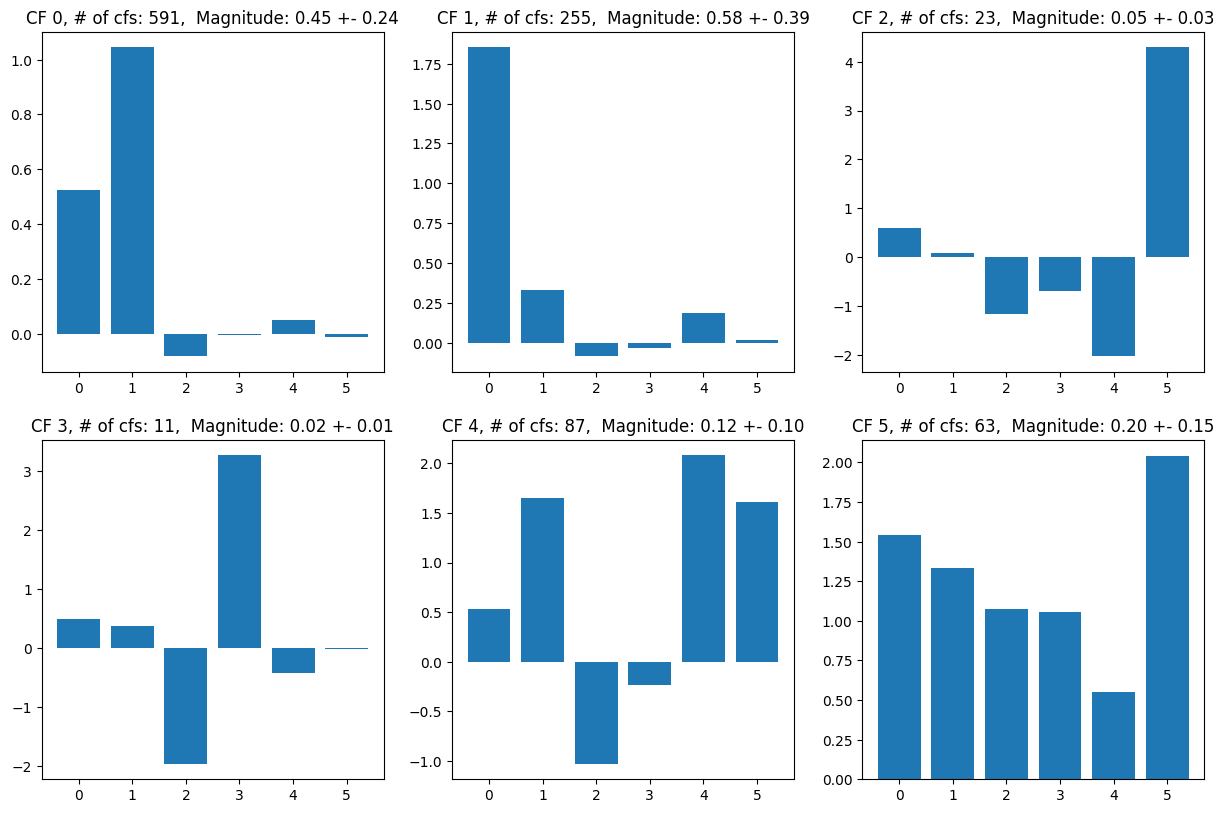

In [54]:
plt.figure(figsize=(15, 15))

groups = S.argmax(dim=1)

for i in range(D.shape[0]):
    plt.subplot(3, 3, i + 1)
    plt.bar(
        range(len(dataset.actionable_features)),
        D[i, dataset.actionable_features].detach().numpy(),
    )
    mean_magn = M.squeeze()[groups == i].mean(axis=0)
    std_magn = M.squeeze()[groups == i].std(axis=0)
    n_vectors = (S.argmax(axis=1) == i).sum()
    plt.title(
        f"CF {i}, # of cfs: {n_vectors},  Magnitude: {mean_magn:.2f} +- {std_magn:.2f}"
    )

In [55]:
dataset.not_actionable_features = [
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
]
dataset.actionable_features = [0, 1]
cf_method = RPPCEF(
    X=X_test_origin,
    cf_method_type="GCE",
    K=6,
    gen_model=gen_model,
    disc_model=disc_model,
    disc_model_criterion=MulticlassDiscLoss(),
    # actionable_features=None,
    actionable_features=dataset.not_actionable_features,
    neptune_run=None,
)

train_dataloader_for_log_prob = dataset.train_dataloader(batch_size=4096, shuffle=False)
log_prob_threshold = torch.quantile(
    gen_model.predict_log_prob(train_dataloader_for_log_prob),
    0.25,
)

cf_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(X_test_origin).float(),
        torch.tensor(y_test_origin).float(),
    ),
    batch_size=4096,
    shuffle=False,
)


delta, Xs, ys_orig, ys_target = cf_method.explain_dataloader(
    dataloader=cf_dataloader,
    epochs=3000,
    lr=0.003,
    patience=300,
    alpha=100,
    alpha_s=1000,
    alpha_k=100,
    log_prob_threshold=log_prob_threshold,
)

M, S, D = delta.get_matrices()
Xs_cfs = Xs + delta().detach().numpy()


metrics = CFMetrics(
    X_cf=Xs_cfs,
    y_target=ys_target,
    X_train=dataset.X_train,
    y_train=dataset.y_train,
    X_test=X_test_origin,
    y_test=y_test_origin,
    disc_model=disc_model,
    gen_model=gen_model,
    continuous_features=list(range(dataset.X_train.shape[1])),
    categorical_features=dataset.categorical_features,
    prob_plausibility_threshold=log_prob_threshold,
)
metrics.calc_all_metrics()

loss: 6470.7964, dist: 0.6087, max_inner: 18.9120, loss_disc: 0.0200, delta_loss: 4379.1113: 100%|██████████| 3000/3000 [00:28<00:00, 105.88it/s]


{'coverage': 1.0,
 'validity': 0.9320388349514563,
 'actionability': 0.0,
 'sparsity': 0.08695652173913043,
 'proximity_categorical_hamming': nan,
 'proximity_categorical_jaccard': 0.4173361852889368,
 'proximity_continuous_manhattan': 0.5541059677193213,
 'proximity_continuous_euclidean': 0.4173361852889368,
 'proximity_continuous_mad': 5.5190977967114785,
 'proximity_l2_jaccard': 0.4173361852889368,
 'proximity_mad_hamming': nan,
 'prob_plausibility': 0.19029126213592232,
 'log_density_cf': 10.819394,
 'log_density_test': 23.583818,
 'lof_scores_cf': 1.4459103,
 'lof_scores_test': 1.1094948,
 'isolation_forest_scores_cf': 0.02968295888907362,
 'isolation_forest_scores_test': 0.04977191510560623}

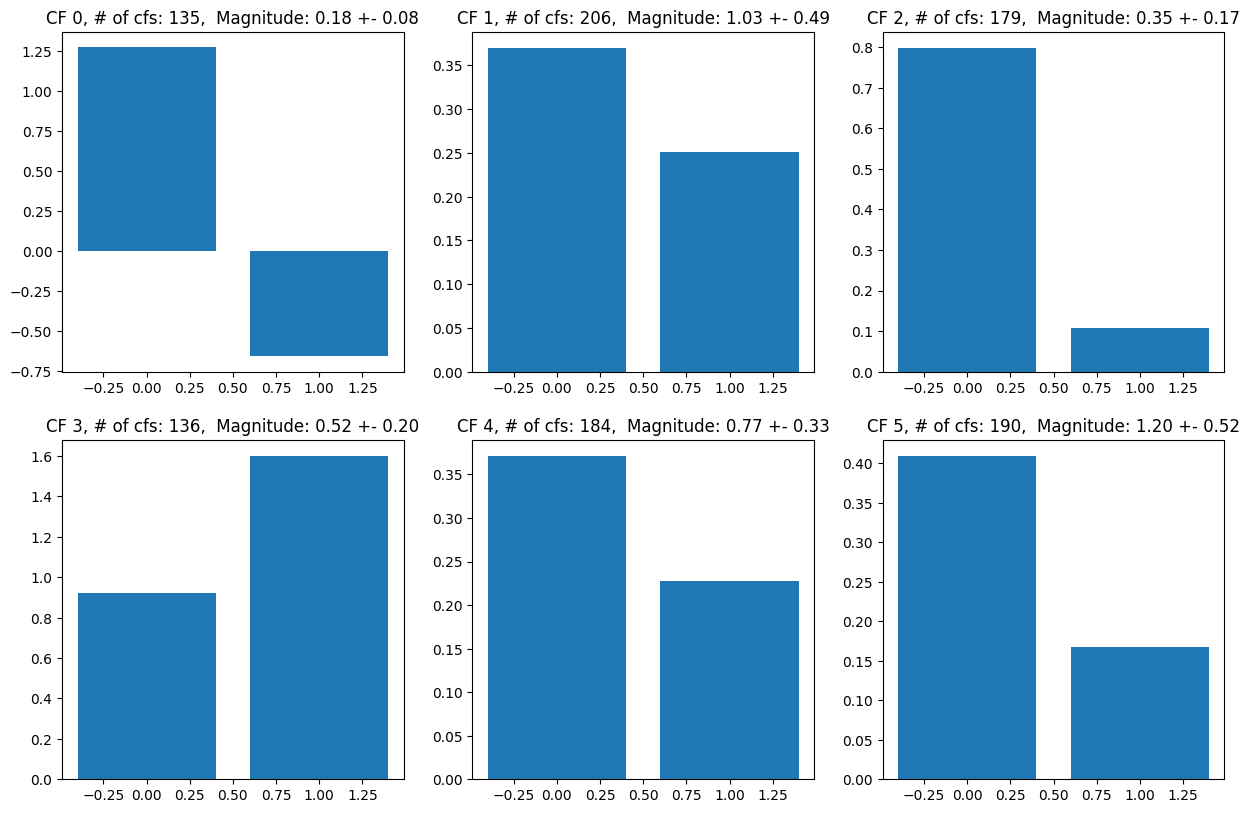

In [56]:
plt.figure(figsize=(15, 15))

groups = S.argmax(dim=1)

for i in range(D.shape[0]):
    plt.subplot(3, 3, i + 1)
    plt.bar(
        range(len(dataset.actionable_features)),
        D[i, dataset.actionable_features].detach().numpy(),
    )
    mean_magn = M.squeeze()[groups == i].mean(axis=0)
    std_magn = M.squeeze()[groups == i].std(axis=0)
    n_vectors = (S.argmax(axis=1) == i).sum()
    plt.title(
        f"CF {i}, # of cfs: {n_vectors},  Magnitude: {mean_magn:.2f} +- {std_magn:.2f}"
    )

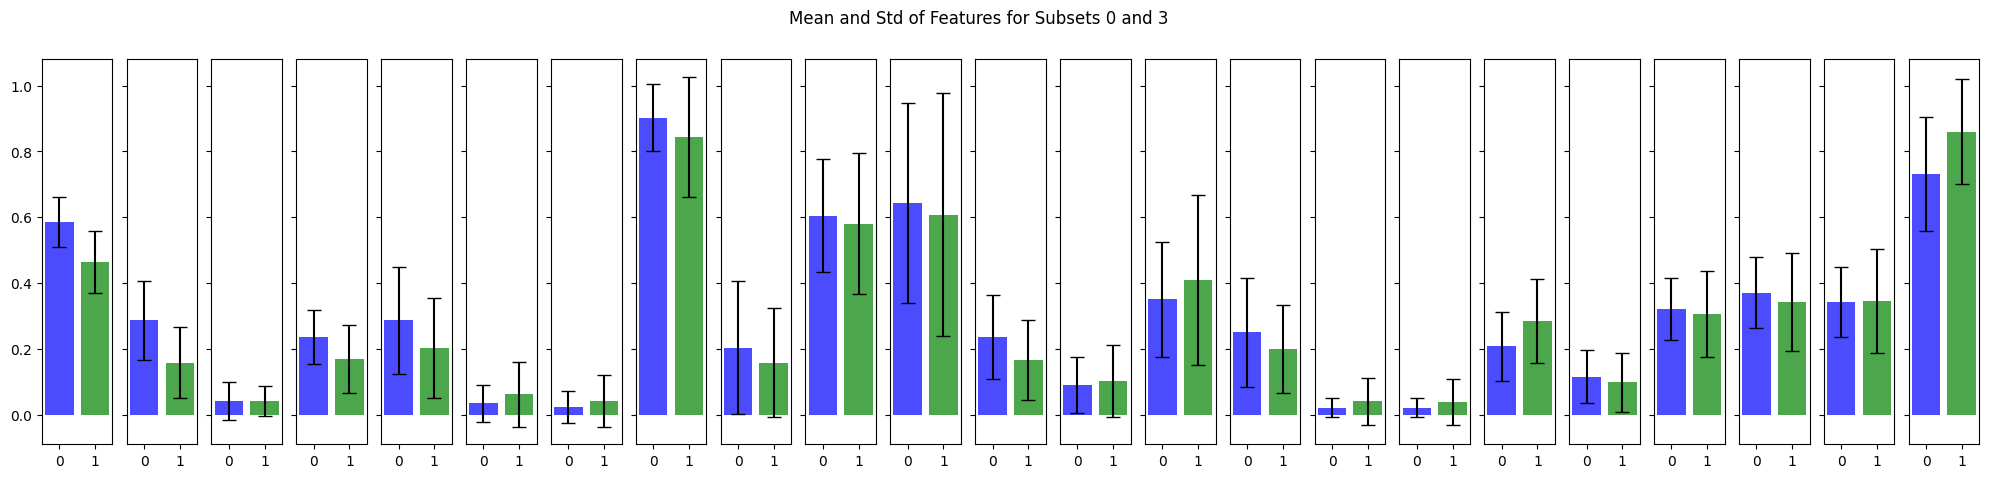

In [60]:
import matplotlib.pyplot as plt

# First subset
subset_0 = X_test_origin[S.argmax(dim=1) == 0]
mean_values_0 = subset_0.mean(axis=0)
std_values_0 = subset_0.std(axis=0)

# Second subset
subset_1 = X_test_origin[S.argmax(dim=1) == 3]
mean_values_1 = subset_1.mean(axis=0)
std_values_1 = subset_1.std(axis=0)

fig, axes = plt.subplots(1, len(mean_values_0), figsize=(25, 5), sharey=True)

for i in range(len(mean_values_0)):
    axes[i].bar(
        0, mean_values_0[i], yerr=std_values_0[i], capsize=5, color="blue", alpha=0.7
    )
    axes[i].bar(
        1, mean_values_1[i], yerr=std_values_1[i], capsize=5, color="green", alpha=0.7
    )
    axes[i].set_xticks([0, 1])
    # axes[i].set_xticklabels(['Subset 0', 'Subset 1'])
    # axes[i].set_title(f'Feature {i}')

fig.suptitle("Mean and Std of Features for Subsets 0 and 3")
plt.show()

In [27]:
# fig, ax = plt.subplots(figsize=(10, 10))
# ax.scatter(Xs_cfs[:, 0], Xs_cfs[:, 1], c=ys_target)
# ax.scatter(Xs[:, 0], Xs[:, 1], c=indexes, marker="x")

# # Add arrows between each Xs and Xs_cfs
# for i in range(len(Xs)):
#     ax.arrow(Xs[i, 0], Xs[i, 1], Xs_cfs[i, 0] - Xs[i, 0], Xs_cfs[i, 1] - Xs[i, 1],
#              head_width=0.02, head_length=0.00, fc='gray', ec='gray', alpha=0.5)

# plot_generative_model_distribution(ax, gen_model, log_prob_threshold, 2)

In [28]:
# options = [
#     {"K": 1, "alpha_plausability": 0, "alpha_search": 0},
#     {"K": max_samples, "alpha_plausability": 0, "alpha_search": 0},
#     {"K": max_samples, "alpha_plausability": 0, "alpha_search": 1000},
#     {"K": 1, "alpha_plausability": 1000, "alpha_search": 0},
#     {"K": max_samples, "alpha_plausability": 1000, "alpha_search": 0},
#     {"K": max_samples, "alpha_plausability": 1000, "alpha_search": 1000},
# ]

# for opt in options:
#     print(opt)
#     K = opt["K"]
#     alpha_plausability = opt["alpha_plausability"]
#     alpha_search = opt["alpha_search"]

#     cf = RPPCEF(
#         K=K,
#         gen_model=gen_model,
#         disc_model=disc_model,
#         disc_model_criterion=BinaryDiscLoss(),
#         neptune_run=None,
#     )

#     cf_dataloader = torch.utils.data.DataLoader(
#         torch.utils.data.TensorDataset(
#             torch.from_numpy(dataset.X_test[dataset.y_test == 0]),
#             torch.from_numpy(dataset.y_test[dataset.y_test == 0]),
#         ),
#         batch_size=1024,
#         shuffle=False,
#     )
#     median_log_prob = torch.median(gen_model.predict_log_prob(cf_dataloader))

#     deltas, X_orig, y_orig, y_target, logs = cf.search_batch(
#         cf_dataloader,
#         alpha=1000,
#         alpha_plausability=alpha_plausability,
#         alpha_search=alpha_search,
#         median_log_prob=median_log_prob,
#         epochs=10000,
#     )

#     M, S, D = deltas[0].get_matrices()
#     print(f"Number of vectors: {(S.sum(axis=0) != 0).sum()}")

#     X_cf = X_orig + deltas[0]().detach().numpy()

#     ## Distribution Plot
#     ax = plot_model_distribution(cf.gen_model, median_log_prob, cf.disc_model)

#     ## Classifier Line
#     w1, w2 = list(disc_model.parameters())[0].detach().cpu().numpy()[0]
#     b = list(disc_model.parameters())[1].detach().cpu().numpy().item()
#     c = -b / w2
#     m = -w1 / w2
#     xmin, xmax = -1.5, 2.5
#     ymin, ymax = -1.5, 2.5
#     xd = np.array([xmin, xmax])
#     yd = m * xd + c
#     plt.plot(xd, yd, "#ADD8E6", lw=2.0, ls="dashed")
#     # plt.axis("off")

#     ## Original points
#     ax.scatter(X_orig[:, 0], X_orig[:, 1], alpha=0.5)

#     ## Counterfactuals
#     ax.scatter(X_cf[:, 0], X_cf[:, 1], c="r")

#     for before, after in zip(X_orig, X_cf):
#         ax.arrow(
#             before[0],
#             before[1],
#             after[0] - before[0],
#             after[1] - before[1],
#             # head_width=0.0,
#             # head_length=0.0,
#             fc="gray",
#             ec="gray",
#             alpha=0.5,
#             width=0.0001,
#         )

#     plt.xlim([-0.10, 1.05])
#     plt.ylim([-0.10, 1.10])
#     plt.tight_layout()

#     ## Save Figure
#     plt.savefig(f"K_{K}_Search_{alpha_search}_Plausability_{alpha_plausability}.pdf")
#     plt.close()